In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point, LineString
import hdbscan
import os
from dotenv import load_dotenv
import requests

%matplotlib inline

Download Capital Ring route buffer
The route and the buffer was done in QGIS
The buffer is 1000m, and allows to capture the POI in the areas along the route

In [2]:
#capital_ring_buffer = gpd.read_file('data/capital_ring_buffer.geojson')
#capital_ring_buffer.plot()

In [3]:
boro_shp = "data/source/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
boro_gdf = gpd.read_file(boro_shp).to_crs('EPSG:27700')
boro_gdf.tail()

city_of_london_boro = (boro_gdf[boro_gdf['NAME'] == 'City of London'])

<Axes: >

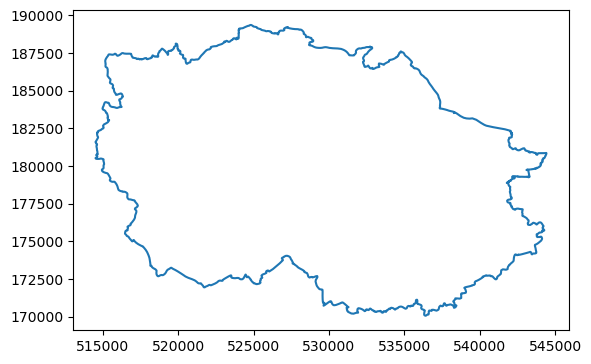

In [4]:
capital_ring_line = gpd.read_file('data/CR_reproject_smooth.geojson')
capital_ring_line.plot()

In [5]:
line = capital_ring_line.iloc[0].geometry  # Extract the LineString geometry

interval = 1000  
distances = range(0, int(line.length), interval)
sampled_points = [line.interpolate(d) for d in distances]

capital_ring_line_sampled_points = gpd.GeoDataFrame(geometry=sampled_points, crs=capital_ring_line.crs)

/tmp/ipykernel_12622/1999879428.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


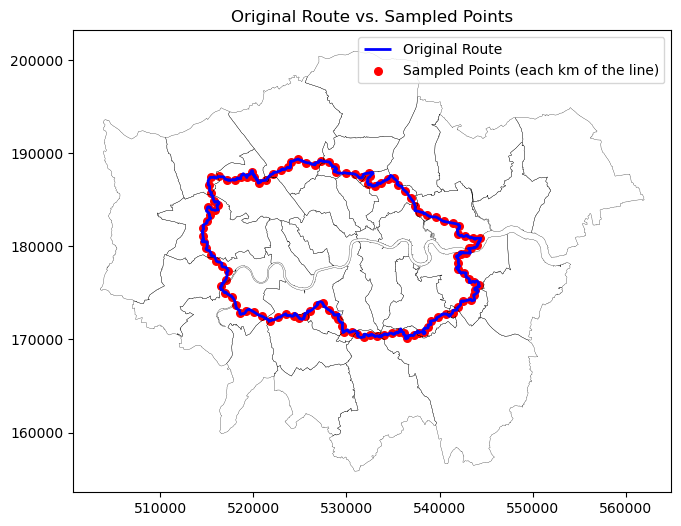

In [6]:
# Plot line and sampled points
fig, ax = plt.subplots(figsize=(10, 6))
capital_ring_line.plot(ax=ax, color='blue', linewidth=2, label="Original Route")
capital_ring_line_sampled_points.plot(ax=ax, color='red', markersize=30, label="Sampled Points (each km of the line)")
boro_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2, label="City of London")

ax.set_aspect('equal')
plt.legend()
plt.title("Original Route vs. Sampled Points")
plt.show()

In [7]:
capital_ring_line_sampled_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  119 non-null    geometry
dtypes: geometry(1)
memory usage: 1.1 KB


In [12]:
# Load environment variables from the .env file
load_dotenv()
# Access the API key, secret key, and endpoint from environment variables
os_key = os.getenv('OS_API_KEY')
os_api_endpoint = 'https://api.os.uk/search/names/v1/nearest'

fq = 'LOCAL_TYPE:Hamlet LOCAL_TYPE:Suburban_Area LOCAL_TYPE:Village LOCAL_TYPE:Town LOCAL_TYPE:Other_Settlement' #which types of places to include
radius = 1000
point = "placeholder"

#print("Full URL:", OS_placenames_url)

In [13]:
places_df = pd.DataFrame()

In [14]:
for i in capital_ring_line_sampled_points['geometry']:
    sampled_point_string = (f"{i.x:.2f},{i.y:.2f}")
    point = sampled_point_string
    os_placenames_url = f"{os_api_endpoint}?point={point}&radius={radius}&fq={fq}&key={os_key}"

    os_response = requests.get(os_placenames_url)

    if os_response.status_code == 200:
        data = os_response.json()
        results = data.get('results', [])
    
        if results:
            df = pd.json_normalize(results)
            places_df = pd.concat([places_df, df], ignore_index=True)
        else:
            print("No results found for point:", point)
    else:
        print(f"Error: {os_response.status_code} - {os_response.text}")

No results found for point: 532439.95,187880.36
No results found for point: 524000.28,189016.34
No results found for point: 521390.53,187155.29
No results found for point: 520573.50,186791.69
No results found for point: 516337.33,187494.40
No results found for point: 515790.45,184875.47
No results found for point: 516176.41,184458.29
No results found for point: 515901.31,183863.73
No results found for point: 515104.00,184178.20
No results found for point: 515313.73,183360.29
No results found for point: 514604.32,181090.24
No results found for point: 515470.40,179115.74
No results found for point: 516030.68,178433.38
No results found for point: 520101.52,172926.31
No results found for point: 523511.72,172736.03
No results found for point: 530575.81,170829.39
No results found for point: 537809.11,170741.06
No results found for point: 538343.21,170819.00
No results found for point: 539876.74,172423.50
No results found for point: 541989.70,173460.30
No results found for point: 543828.49,17

In [15]:
places_df['geometry'] = places_df.apply(lambda row: Point(row['GAZETTEER_ENTRY.GEOMETRY_X'], row['GAZETTEER_ENTRY.GEOMETRY_Y']), axis=1)
places_gdf = gpd.GeoDataFrame(places_df, geometry='geometry')

#There are some duplicated entries
places_gdf = places_gdf.drop_duplicates(subset=['geometry'], keep='first')
print(f"Found {len(places_gdf)} places.")
places_gdf.head()

Found 65 places.


,GAZETTEER_ENTRY.ID,GAZETTEER_ENTRY.NAMES_URI,GAZETTEER_ENTRY.NAME1,GAZETTEER_ENTRY.TYPE,GAZETTEER_ENTRY.LOCAL_TYPE,GAZETTEER_ENTRY.GEOMETRY_X,GAZETTEER_ENTRY.GEOMETRY_Y,GAZETTEER_ENTRY.MOST_DETAIL_VIEW_RES,GAZETTEER_ENTRY.LEAST_DETAIL_VIEW_RES,GAZETTEER_ENTRY.MBR_XMIN,...,GAZETTEER_ENTRY.COUNTY_UNITARY,GAZETTEER_ENTRY.COUNTY_UNITARY_URI,GAZETTEER_ENTRY.COUNTY_UNITARY_TYPE,GAZETTEER_ENTRY.REGION,GAZETTEER_ENTRY.REGION_URI,GAZETTEER_ENTRY.COUNTRY,GAZETTEER_ENTRY.COUNTRY_URI,GAZETTEER_ENTRY.SAME_AS_GEONAMES,GAZETTEER_ENTRY.SAME_AS_DBPEDIA,geometry
0,osgb4000000074578781,http://data.ordnancesurvey.co.uk/id/4000000074...,North Woolwich,populatedPlace,Suburban Area,543058.0,179748.0,12000,25000,542550.0,...,Greater London,http://data.ordnancesurvey.co.uk/id/7000000000...,http://data.ordnancesurvey.co.uk/ontology/admi...,London,http://data.ordnancesurvey.co.uk/id/7000000000...,England,http://data.ordnancesurvey.co.uk/id/country/en...,http://sws.geonames.org/2641215,http://dbpedia.org/resource/North_Woolwich,POINT (543058 179748)
1,osgb4000000074820388,http://data.ordnancesurvey.co.uk/id/4000000074...,Cavendish Square,populatedPlace,Other Settlement,544260.0,180702.0,15000,25000,543997.0,...,Greater London,http://data.ordnancesurvey.co.uk/id/7000000000...,http://data.ordnancesurvey.co.uk/ontology/admi...,London,http://data.ordnancesurvey.co.uk/id/7000000000...,England,http://data.ordnancesurvey.co.uk/id/country/en...,NaN,NaN,POINT (544260 180702)
3,osgb4000000074578782,http://data.ordnancesurvey.co.uk/id/4000000074...,Cyprus,populatedPlace,Suburban Area,543493.0,180920.0,4000,25000,543159.0,...,Greater London,http://data.ordnancesurvey.co.uk/id/7000000000...,http://data.ordnancesurvey.co.uk/ontology/admi...,London,http://data.ordnancesurvey.co.uk/id/7000000000...,England,http://data.ordnancesurvey.co.uk/id/country/en...,NaN,NaN,POINT (543493 180920)
4,osgb4000000074579017,http://data.ordnancesurvey.co.uk/id/4000000074...,Beckton,populatedPlace,Suburban Area,542951.0,181665.0,20000,25000,541701.0,...,Greater London,http://data.ordnancesurvey.co.uk/id/7000000000...,http://data.ordnancesurvey.co.uk/ontology/admi...,London,http://data.ordnancesurvey.co.uk/id/7000000000...,England,http://data.ordnancesurvey.co.uk/id/country/en...,http://sws.geonames.org/2656052,http://dbpedia.org/resource/Beckton,POINT (542951 181665)
5,osgb4000000074303145,http://data.ordnancesurvey.co.uk/id/4000000074...,Custom House,populatedPlace,Suburban Area,541796.0,181497.0,11000,25000,540599.0,...,Greater London,http://data.ordnancesurvey.co.uk/id/7000000000...,http://data.ordnancesurvey.co.uk/ontology/admi...,London,http://data.ordnancesurvey.co.uk/id/7000000000...,England,http://data.ordnancesurvey.co.uk/id/country/en...,NaN,"http://dbpedia.org/resource/Custom_House,_London",POINT (541796 181497)


/tmp/ipykernel_12622/3585290458.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


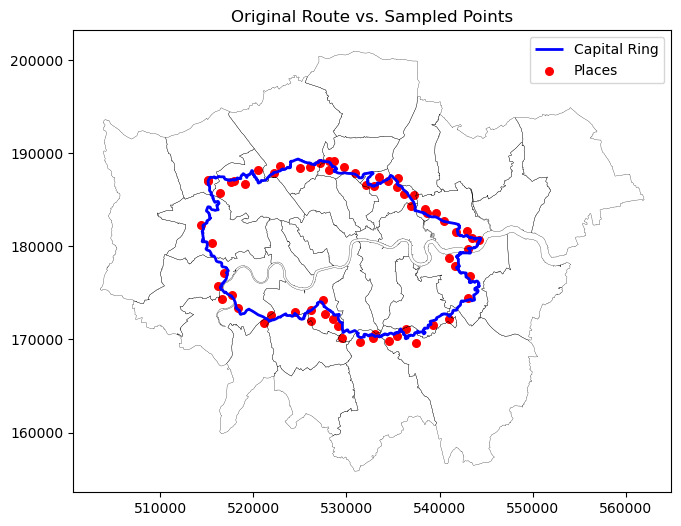

In [16]:
# Plot line and sampled points
fig, ax = plt.subplots(figsize=(10, 6))
capital_ring_line.plot(ax=ax, color='blue', linewidth=2, label="Capital Ring")
places_gdf.plot(ax=ax, color='red', markersize=30, label="Places")
boro_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2, label="City of London")

ax.set_aspect('equal')
plt.legend()
plt.title("Original Route vs. Sampled Points")
plt.show()

In [17]:
print(places_gdf.iloc[2]["geometry"])
places_gdf.set_crs('EPSG:27700', inplace=True)
print(places_gdf.crs)

POINT (543493 180920)
EPSG:27700


In [18]:
#Setting params for Wikipedia API
wiki_api_endpoint = 'https://en.wikipedia.org/w/api.php?action=query&list=geosearch'
radius = 1000

#Reprojecting gdf to fit the API requirements
places_gdf_wgs84 = places_gdf.to_crs(4258)
print(places_gdf_wgs84.crs)
print(places_gdf_wgs84.iloc[2]["geometry"]) #ensuring the coordinates have transformed

EPSG:4258
POINT (0.0663244855967091 51.5089966434229)


In [20]:
# Getting data from Wikipedia API
wiki_df = pd.DataFrame()

for index, i in enumerate(places_gdf_wgs84["geometry"]):
    lat = i.y
    lon = i.x
    wiki_url = f"{wiki_api_endpoint}&gsradius={radius}&gscoord={lat}|{lon}&gslimit=500&format=json"
    wiki_response = requests.get(wiki_url)
#    print(Wiki_url)
#    print(Wiki_response.status_code)
    if wiki_response.status_code == 200:
        data = wiki_response.json()
        results = data.get('query', []).get('geosearch', [])   

        # print(data.keys())
        # print(results)
        if results:
            df = pd.json_normalize(results)
            df['place_index'] = index
            wiki_df = pd.concat([wiki_df, df], ignore_index=True)
#            print(wiki_df.shape)
        else:
            print("No results found for point:", i)
    else:
        print(f"Error: {wiki_response.status_code} - {wiki_response.text}")
#    if index == 5:  # Stop after the item N - for testing
#       break

In [21]:
wiki_df

,pageid,ns,title,lat,lon,dist,primary,place_index
0,353306,0,Woolwich foot tunnel,51.498790,0.061650,144.9,,0
1,8609500,0,North Woolwich railway station,51.499400,0.062300,209.1,,0
2,10737078,0,Royal Docks Heritage Railway,51.499400,0.062300,209.1,,0
3,51859566,0,"St John's Church, North Woolwich",51.500702,0.058687,244.5,,0
4,1326226,0,North Woolwich Old Station Museum,51.499722,0.063056,272.0,,0
...,...,...,...,...,...,...,...,...
1349,30154806,0,Holborn College,51.491800,0.042100,861.8,,64
1350,76947,0,Thames Barrier,51.496944,0.036667,883.5,,64
1351,9325178,0,"Hanging Wood, London",51.489000,0.043000,915.3,,64
1352,5323911,0,Maryon Park,51.489000,0.043000,915.3,,64


In [22]:
wiki_df["geometry"] = wiki_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
wiki_gdf = gpd.GeoDataFrame(wiki_df, geometry="geometry")
wiki_gdf.set_crs(4258, inplace=True)
wiki_gdf = wiki_gdf.to_crs(27700)

wiki_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pageid       1354 non-null   int64   
 1   ns           1354 non-null   int64   
 2   title        1354 non-null   object  
 3   lat          1354 non-null   float64 
 4   lon          1354 non-null   float64 
 5   dist         1354 non-null   float64 
 6   primary      1354 non-null   object  
 7   place_index  1354 non-null   int64   
 8   geometry     1354 non-null   geometry
dtypes: float64(3), geometry(1), int64(3), object(2)
memory usage: 95.3+ KB


/tmp/ipykernel_12622/2311409148.py:9: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


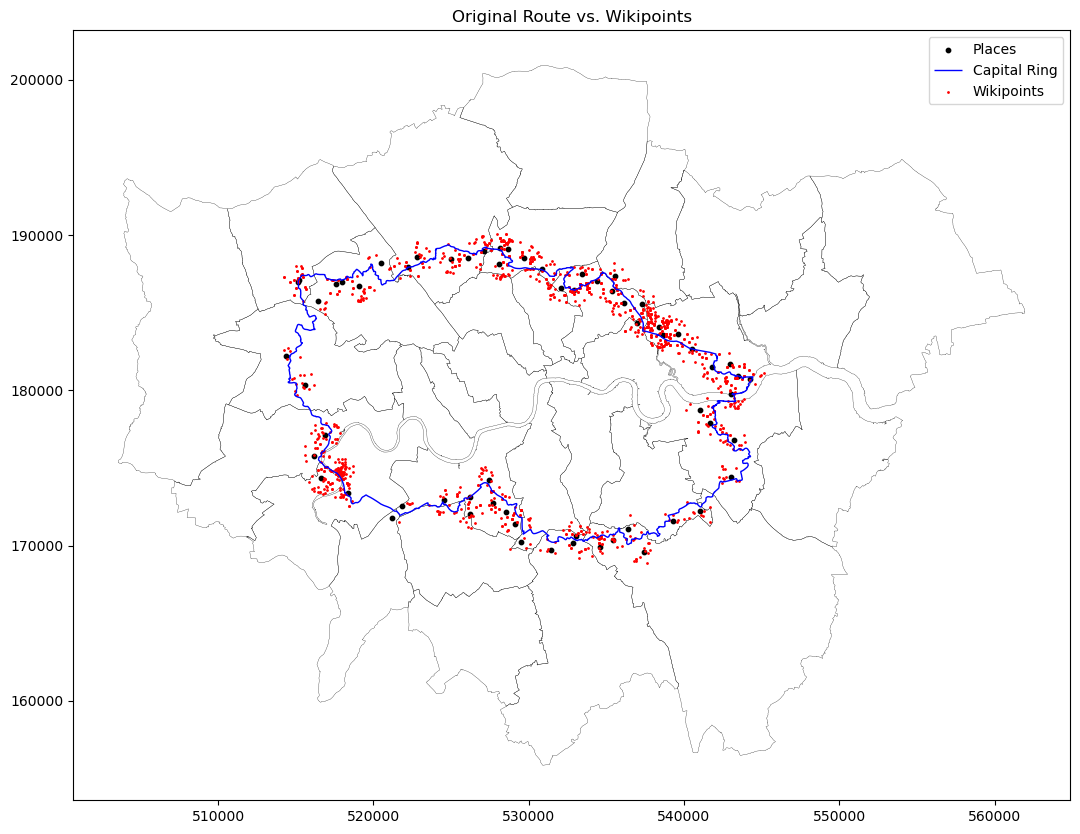

In [23]:
# Plot line and sampled points
fig, ax = plt.subplots(figsize=(20, 10))
places_gdf.plot(ax=ax, color='black', markersize=10, label="Places")
capital_ring_line.plot(ax=ax, color='blue', linewidth=1, label="Capital Ring")
boro_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2, label="City of London")
wiki_gdf.plot(ax=ax, color='red', markersize=1, label="Wikipoints")

ax.set_aspect('equal')
plt.legend()
plt.title("Original Route vs. Wikipoints")
plt.show()

In [24]:
#i am removing duplicates first
print(len(wiki_gdf))
wiki_gdf = wiki_gdf.drop_duplicates(subset=['geometry'], keep='first')
print(len(wiki_gdf))

1354
920


In [ ]:
#Now I need to remove those wikipoints that are of the category that I don't want

The points are too close to each other. We need to perfom cluster analysis to determine, which points are part of the place, and which got into the 1000m radius by chance. We observe:
- The route goes through places with different number of wikipoints;
- There are some outliers;
- We can approximate the number of clusters, however,
- The points are arranged around the place point, but there are many overlaps, and
- There may be points with little or no wikipoints.

The proposed clustering technique is HDBSCAN, because it is:
- Appropriate for different densities;
- Handling outliers.

In [ ]:
# Extract coordinates from GeoDataFrame
coords_wiki_clustering = np.array([[p.x, p.y] for p in wiki_gdf.geometry])

# Run HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1, cluster_selection_epsilon=50).fit(coords_wiki_clustering)

# Assign cluster labels
wiki_gdf["cluster"] = hdb.labels_

# Mark and remove outliers (-1 means outlier)
#wiki_gdf = wiki_gdf[wiki_gdf["cluster"] != -1]

In [ ]:
# Generate a list of unique clusters from the 'clusters' column in wiki_gdf
unique_clusters = wiki_gdf['cluster'].unique()
# Create a colormap (we can use tab20 or any other colormap)
colormap = plt.cm.get_cmap('tab20', len(unique_clusters))  # Assigning a specific number of colors
colors = [colormap(i) for i in range(len(unique_clusters))]  # Generating a list of colors for clusters

fig, ax = plt.subplots(figsize=(20, 10))

places_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, markersize=20, label="Places")
# Add labels to the places
for idx, row in places_gdf.iterrows():
    ax.text(row.geometry.x, row.geometry.y, str(row['GAZETTEER_ENTRY.NAME1']), fontsize=5, ha='right', color='black', fontweight='regular')


capital_ring_line.plot(ax=ax, color='blue', linewidth=1, label="Capital Ring")
#boro_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2, label="City of London")

for idx, cluster in enumerate(unique_clusters):
    cluster_points = wiki_gdf[wiki_gdf['cluster'] == cluster]
    
    if cluster != -1:
        cluster_points.plot(ax=ax, color=colors[idx], markersize=5, label=f"Cluster {cluster}")
    else: 
        cluster_points.plot(ax=ax, color='black', markersize=6, label=f"Outlier {cluster}")

ax.set_aspect('equal')
#plt.legend()
plt.title("Original Route vs. Wikipoints with Clusters")
plt.show()